In [1]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
from skimage import io, color
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

In [2]:
# general parameters
model_name = 'Vit_google'
dataset_name ='BreakHis'
fold = 'fold1' # options: fold1, fold2, fold3, fold4, fold1
mag = '200X'   # options: 40X, 100X, 200X, 400X, combined

In [3]:
# paths
model_path = 'Models/'+model_name+'_'+fold+'_'+mag+'.pth'
folder_path = 'Graphs/'+model_name+'_'+fold+'_'+mag+'/'
print(model_path)
print(folder_path)

Models/Vit_google_fold1_200X.pth
Graphs/Vit_google_fold1_200X/


In [4]:
img_path = 'BreakHis/fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

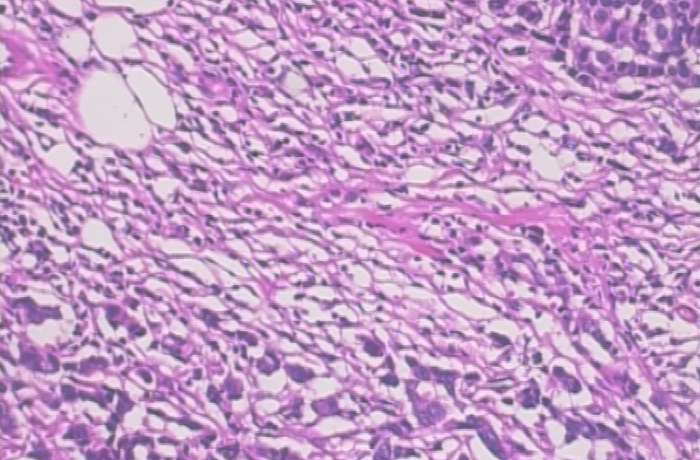

In [5]:
img

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
#data_path = 'BreakHis/fold1_seperated_2_classes/train/40X'
training_dataset_path = 'BreakHis/'+fold+'_seperated_2_classes/train/'+mag
testing_dataset_path = 'BreakHis/'+fold+'_seperated_2_classes/test/'+mag

In [8]:
def image_transform(mag):
    if mag == '40X':
        transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize( mean =  [0.8058, 0.6418, 0.7678], std = [0.0880, 0.1171, 0.0879])
        ])
        
    if mag == '100X':
        transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.8004, 0.6275, 0.7693], std = [0.1012, 0.1368, 0.0902])
        ])
        
    if mag == '200X':
        transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.7920, 0.6120, 0.7663], std = [0.1043, 0.1375, 0.0836])
        ])
    if mag == '400X':
        transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.7590, 0.5809, 0.7404],std = [0.1195, 0.1602, 0.0887])
        ])
    if mag == 'combined':
        transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.7900, 0.6163, 0.7614], std = [0.1038, 0.1382, 0.0885])
        ])
    
    return transform

In [9]:
transform =  image_transform(mag)

In [10]:
X = transform(img).unsqueeze_(0)

In [11]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [12]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1269
    Root location: BreakHis/fold1_seperated_2_classes/train/200X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.792, 0.612, 0.7663], std=[0.1043, 0.1375, 0.0836])
           )

In [13]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 744
    Root location: BreakHis/fold1_seperated_2_classes/test/200X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.792, 0.612, 0.7663], std=[0.1043, 0.1375, 0.0836])
           )

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 16,shuffle=True)

In [15]:
#Splitting Training Data into Training and Validation
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx) 
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 16,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=16, sampler=val_sampler)

Vision Transformer

In [16]:
from transformers import ViTModel, ViTConfig

# Create a configuration object
config = ViTConfig(
    image_size=512,
    patch_size=64,
    num_channels=3,
    num_labels=2,  # Adjust this based on your number of classes
    hidden_size=1024,
    num_hidden_layers=6,
    num_attention_heads=4,
    intermediate_size=4096,
)

# Instantiate the model using the configuration
base_model = ViTModel(config)

In [17]:
class ViTForImageClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)
    
    def forward(self,images):
        embeds = self.base_model.embeddings(images)
        attns = self.base_model.encoder(embeds)
        last_hidden_state = attns.last_hidden_state
        norm = self.base_model.layernorm(last_hidden_state)        
        out = norm[:,0]
        logits = self.classifier(out)
        return logits

model = ViTForImageClassification(base_model, num_labels=2)

In [18]:
model = model.to(device)

In [19]:
model(X.to(device))

tensor([[-0.3309, -0.2415]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
model

ViTForImageClassification(
  (base_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(64, 64), stride=(64, 64))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear

In [21]:
N_EPOCHS = 150
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9,weight_decay=0.03)
criterion = CrossEntropyLoss()

In [22]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [23]:
def train_nn(model, train_loader, test_loader,criterion,optimizer,n_epochs):
  device = set_device()
  best_acc = 0
  train_losses = []
  train_acc = []
  val_acc = []
  val_losses = []
  model = model.to(device)
  for epoch in range(n_epochs):
    print("Epoch number: %d"%(epoch+1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for data in train_loader:
      images,labels = data
      images = images.to(device) #for faster processing
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad() #Set grad = 0 before back prop
      outputs = model(images)

      _,predicted = torch.max(outputs.data,1)
    
      loss = criterion(outputs,labels)
      loss.backward() #Calculate Weight gradients
      optimizer.step() #update weights
      running_loss += loss.item()
      running_correct += (labels==predicted).sum().item()
      
    

    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.0*running_correct/total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)

    print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f"%(running_correct, total, epoch_acc,epoch_loss))
    test_dataset_acc, test_dataset_loss = evaluate_model(model,test_loader,criterion)
    val_acc.append(test_dataset_acc)
    val_losses.append(test_dataset_loss) 

    if (test_dataset_acc>best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model,epoch,optimizer,best_acc)

  print('Finished Training')
  return model,train_losses,train_acc,val_acc,val_losses

In [24]:
def save_checkpoint(model,epoch,optimizer, best_acc):
  state = {
      'epoch': epoch + 1,
      'model': model.state_dict(),
      'best accuracy': best_acc,
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state, model_path)

In [25]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): #Used for not backpropogating which improves computation speed
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) #total amount of images

            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [26]:
#Train the model
history, train_losses, train_acc, val_acc, val_losses = train_nn(model, train_loader,val_loader, criterion, optimizer ,N_EPOCHS)

Epoch number: 1
  -Training Dataset, Got 1050 out of 1269 images correctly (82.742%). Epoch Loss: 0.390
-  Testing dataset. Got 190 out of 223 images correctly (85.202%). Loss: 0.413
Epoch number: 2
  -Training Dataset, Got 1126 out of 1269 images correctly (88.731%). Epoch Loss: 0.249
-  Testing dataset. Got 195 out of 223 images correctly (87.444%). Loss: 0.456
Epoch number: 3
  -Training Dataset, Got 1140 out of 1269 images correctly (89.835%). Epoch Loss: 0.223
-  Testing dataset. Got 197 out of 223 images correctly (88.341%). Loss: 0.421
Epoch number: 4
  -Training Dataset, Got 1149 out of 1269 images correctly (90.544%). Epoch Loss: 0.196
-  Testing dataset. Got 200 out of 223 images correctly (89.686%). Loss: 0.440
Epoch number: 5
  -Training Dataset, Got 1157 out of 1269 images correctly (91.174%). Epoch Loss: 0.183
-  Testing dataset. Got 193 out of 223 images correctly (86.547%). Loss: 0.469
Epoch number: 6
  -Training Dataset, Got 1183 out of 1269 images correctly (93.223%).

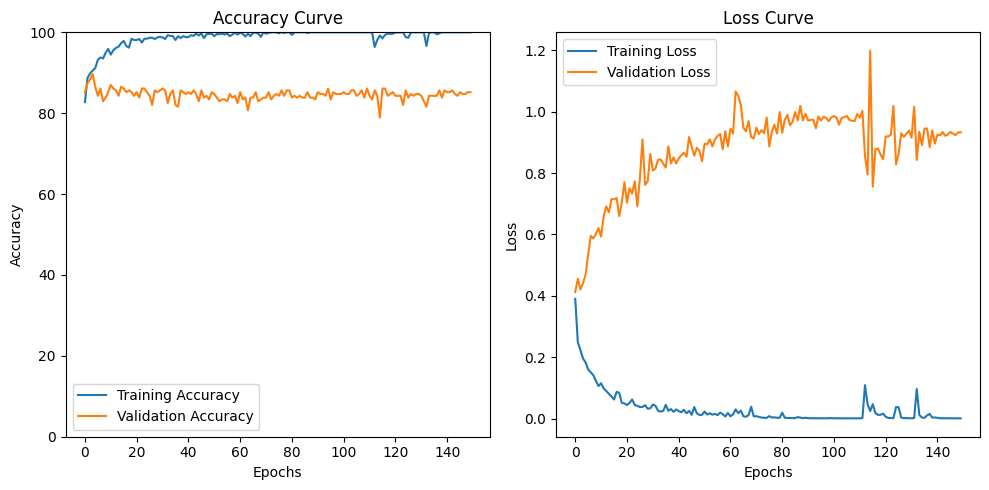

In [27]:
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(figsize=(10, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.ylim(0,100)  # Set y-axis limits from 0 to 100 for uniformity
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy_curve_'+model_name+'_'+mag+'.png'))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss_curve_'+model_name+'_'+mag+'.png'))

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'training_curves_'+model_name+'_'+mag+'.png'))

plt.show()

In [28]:
model_path = model_path
check = torch.load(model_path)

In [29]:
check['best accuracy']

89.68609865470852

In [30]:
model.load_state_dict(check['model'])

<All keys matched successfully>

In [31]:
from ptflops import get_model_complexity_info

# Define a function to compute FLOPS
def get_flops(model, input_size):
    flops, params = get_model_complexity_info(model, input_size, as_strings=True, print_per_layer_stat=True)
    print(f"FLOPs: {flops}")
    print(f"Parameters: {params}")
    return flops, params 

In [32]:
# Define the input size. Here, it's a single image with 3 channels and size 512x512
input_size = (3,512,512)

# Compute FLOPS for the ViTForImageClassification model
flops, params  = get_flops(model, input_size)

ViTForImageClassification(
  89.21 M, 99.924% Params, 5.72 GMac, 99.098% MACs, 
  (base_model): ViTModel(
    89.21 M, 99.922% Params, 5.72 GMac, 99.098% MACs, 
    (embeddings): ViTEmbeddings(
      12.58 M, 14.095% Params, 805.37 MMac, 13.960% MACs, 
      (patch_embeddings): ViTPatchEmbeddings(
        12.58 M, 14.095% Params, 805.37 MMac, 13.960% MACs, 
        (projection): Conv2d(12.58 M, 14.095% Params, 805.37 MMac, 13.960% MACs, 3, 1024, kernel_size=(64, 64), stride=(64, 64))
      )
      (dropout): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      75.58 M, 84.650% Params, 4.91 GMac, 85.137% MACs, 
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          12.6 M, 14.108% Params, 818.62 MMac, 14.190% MACs, 
          (attention): ViTAttention(
            4.2 M, 4.702% Params, 272.9 MMac, 4.730% MACs, 
            (attention): ViTSelfAttention(
              3.15 M, 3.527% Params, 204.67 MMac, 3.548% MACs, 
    

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model_classification_report(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            #print(labels)
            true_labels.extend(labels.cpu().numpy())
            outputs = model(images)
            #print(outputs)
            outputs1 = outputs.cpu().numpy().argmax(axis=1)
            predicted_labels.extend(outputs1)

    return true_labels, predicted_labels

def computeMetrics(true_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    roc  = roc_auc_score(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    pre = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    return tn, fp, fn, tp, acc, pre, recall, f1, roc

In [34]:
import pandas as pd
true_labels, predicted_labels = evaluate_model_classification_report(model, test_loader)
#print(true_labels)
#print(predicted_labels)
print(classification_report(true_labels, predicted_labels))

tn, fp, fn, tp, acc, pre,recall, f1, roc = computeMetrics(true_labels, predicted_labels)
df = pd.read_csv("results.csv")
df.loc[len(df),:]=[model_name, dataset_name, fold, mag, 'test', tn, fp, fn, tp, acc, pre,recall, f1, roc,flops, params]
df.to_csv("results.csv", index=False)

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       185
           1       0.82      0.96      0.89       336

    accuracy                           0.84       521
   macro avg       0.86      0.79      0.81       521
weighted avg       0.85      0.84      0.83       521

